## Harmonize long-read and short-read AnnData objects [M132TS Downsampling Analysis]

This notebooks harmonizes long-read and short-read AnnData objects (e.g. mutual barcodes, mutual genes, etc.) and produces several AnnData outputs and figures, including a scrubbed AnnData object for Seurat SCT analysis.

**Inputs and Outputs**
- Inputs:
  - `M132TS_immune.h5ad`: short-reads AnnData object (immune component)
  - `M132TS_MAS_15x_m64020e_210506_132139_gene_tx_expression_count_matrix_tx_gene_counts_adata.h5ad`: long-reads counts matrix (raw)
- Outputs:
  - harmonized long-reads and short-reads AnnData objects (raw counts, all genes)
  - harmonized long-reads and short-reads AnnData objects (raw counts, all genes, metadata and unstructured data removed [for Seurat SCT analysis])
  - harmonized long-reads and short-reads AnnData objects (raw counts, mutual genes)
  - short vs. long gene expression concordance
  - gene- and transcript- level saturation curves + fit

In [9]:
%matplotlib inline

import os
import sys
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import logging
from operator import itemgetter

import scanpy as sc
import anndata

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = logger.warning

import warnings
warnings.filterwarnings("ignore")

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [10]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'
long_tx_counts_root ='data/t-cell-vdj/long/quant/ds'
short_h5_path = 'output/t-cell-vdj-cite-seq/M132TS_immune.h5ad'
output_root = 'output/t-cell-vdj-cite-seq/ds'
fig_output_root = 'output/t-cell-vdj-cite-seq/ds/figures'

output_prefix = 'M132TS_immune'

ADATA_SHORT_GENE_IDS_COL = 'gene_ids'
ADATA_LONG_GENE_IDS_COL = 'gencode_overlap_gene_ids'

In [11]:
# load sample metadata
import yaml

with open('./downsampling_series_sample_metadata.yaml', 'r') as f:
    sample_meta_dict = yaml.safe_load(f)    

# choose sample key to process
sample_key = 'gencode_st2_ds_masseq'

In [12]:
long_tx_counts_h5_path = os.path.join(
    repo_root, long_tx_counts_root, sample_meta_dict[sample_key])

output_prefix_full = f'{output_prefix}_{sample_key}'

harmonized_long_adata_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_harmonized_long.h5ad')

harmonized_short_adata_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_harmonized_short.h5ad')

harmonized_long_adata_mutual_genes_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_harmonized_long_mutual_genes.h5ad')

harmonized_short_adata_mutual_genes_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_harmonized_short_mutual_genes.h5ad')

harmonized_long_adata_seurat_input_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_harmonized_long_seurat_input.h5ad')

harmonized_short_adata_seurat_input_h5_path = os.path.join(
    repo_root, output_root, f'{output_prefix_full}_harmonized_short_seurat_input.h5ad')

In [13]:
# ... and other stuff this adata:
adata_short = sc.read(os.path.join(repo_root, short_h5_path)).raw.to_adata()

In [14]:
adata_long = sc.read(os.path.join(repo_root, long_tx_counts_h5_path))
adata_long.var_names_make_unique()
adata_long.obs = adata_long.obs.drop('Cell Barcode', axis=1)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Align long adata to short adata

In [234]:
adata_gene_info_set = set(zip(
    adata_long.var[ADATA_LONG_GENE_IDS_COL].values,
    adata_long.var['is_de_novo'].values,
    adata_long.var['is_gene_id_ambiguous'].values))

gene_ids_set = set(map(itemgetter(0), adata_gene_info_set))
n_total_genes = len(gene_ids_set)
n_de_novo_genes = sum(map(lambda gene_id: gene_id.find('STRG') == 0, gene_ids_set))
n_gencode_genes = sum(map(lambda gene_id: gene_id.find('ENS') == 0, gene_ids_set))

print(f'all long adata genes: {n_total_genes}')
print(f'gencode long adata genes: {n_gencode_genes}')
print(f'de novo long adata genes: {n_de_novo_genes}')

all long adata genes: 37699
gencode long adata genes: 21088
de novo long adata genes: 16611


In [235]:
from collections import Counter

adata_short_gene_id_set = set(adata_short.var[ADATA_SHORT_GENE_IDS_COL].values)
adata_long_gene_id_set = set(adata_long.var[ADATA_LONG_GENE_IDS_COL].values)

# drop gencode version suffix ...
drop_version = lambda entry: entry.split('.')[0] if entry.find('ENS') == 0 else entry

unversioned_adata_short_gene_id_counter = Counter([
    drop_version(entry) for entry in adata_short_gene_id_set])
unversioned_adata_long_gene_id_counter = Counter([
    drop_version(entry) for entry in adata_long_gene_id_set])

ver_unambiguous_adata_short_gene_id_list = [
    gene_id for gene_id in unversioned_adata_short_gene_id_counter.keys()
    if unversioned_adata_short_gene_id_counter[gene_id] == 1]
ver_unambiguous_adata_long_gene_id_list = [
    gene_id for gene_id in unversioned_adata_long_gene_id_counter.keys()
    if unversioned_adata_long_gene_id_counter[gene_id] == 1]

gene_id_ambiguous_adata_long_unversioned_gene_id_set = set(map(
    drop_version,
    adata_long[:, adata_long.var['is_gene_id_ambiguous']].var[ADATA_LONG_GENE_IDS_COL].values))

gencode_gene_overlap_ambiguous_adata_long_unversioned_gene_id_set = set(map(
    drop_version,
    adata_long[:, adata_long.var['is_gencode_gene_overlap_ambiguous']].var[ADATA_LONG_GENE_IDS_COL].values))

final_unversioned_unambiguous_mutual_gene_id_set = \
    set(ver_unambiguous_adata_long_gene_id_list) \
    .intersection(ver_unambiguous_adata_short_gene_id_list) \
    .difference(gene_id_ambiguous_adata_long_unversioned_gene_id_set) \
#     .difference(gencode_gene_overlap_ambiguous_adata_long_unversioned_gene_id_set)

print(f'adata_short_gene_id_set: {len(adata_short_gene_id_set)}')
print(f'adata_long_gene_id_set: {len(adata_long_gene_id_set)}')
print(f'ver_unambiguous_adata_short_gene_id_list: {len(ver_unambiguous_adata_short_gene_id_list)}')
print(f'ver_unambiguous_adata_long_gene_id_list: {len(ver_unambiguous_adata_long_gene_id_list)}')
print(f'gene_id_ambiguous_adata_long_unversioned_gene_id_set: {len(gene_id_ambiguous_adata_long_unversioned_gene_id_set)}')
print(f'gencode_gene_overlap_ambiguous_adata_long_unversioned_gene_id_set: {len(gencode_gene_overlap_ambiguous_adata_long_unversioned_gene_id_set)}')
print(f'final_unversioned_unambiguous_mutual_gene_id_set: {len(final_unversioned_unambiguous_mutual_gene_id_set)}')

adata_short_gene_id_set: 16200
adata_long_gene_id_set: 37699
ver_unambiguous_adata_short_gene_id_list: 16200
ver_unambiguous_adata_long_gene_id_list: 37699
gene_id_ambiguous_adata_long_unversioned_gene_id_set: 594
gencode_gene_overlap_ambiguous_adata_long_unversioned_gene_id_set: 8280
final_unversioned_unambiguous_mutual_gene_id_set: 13583


In [236]:
final_adata_short_mutual_keep_var_indices = [
    var_idx
    for var_idx, gene_id in enumerate(adata_short.var[ADATA_SHORT_GENE_IDS_COL])
    if drop_version(gene_id) in final_unversioned_unambiguous_mutual_gene_id_set]

final_adata_long_mutual_keep_var_indices = [
    var_idx
    for var_idx, gene_id in enumerate(adata_long.var[ADATA_LONG_GENE_IDS_COL])
    if drop_version(gene_id) in final_unversioned_unambiguous_mutual_gene_id_set]

# sort both by gene_ids
final_adata_short_mutual_keep_var_indices = sorted(
    final_adata_short_mutual_keep_var_indices,
    key=lambda idx: drop_version(adata_short.var[ADATA_SHORT_GENE_IDS_COL].values[idx]))

final_adata_long_mutual_keep_var_indices = sorted(
    final_adata_long_mutual_keep_var_indices,
    key=lambda idx: drop_version(adata_long.var[ADATA_LONG_GENE_IDS_COL].values[idx]))

In [237]:
# subset long adata barcodes to short adata
adata_short_barcodes_set = set(adata_short.obs.index.values)
adata_long_keep_indices = []
found_barcodes_set = set()
for idx, bc in enumerate(adata_long.obs.index.values):
    if bc in adata_short_barcodes_set:
        adata_long_keep_indices.append(idx)
        found_barcodes_set.add(bc)
not_found_barcodes_set = adata_short_barcodes_set.difference(found_barcodes_set)

if len(not_found_barcodes_set) > 0:
    print(f'{len(not_found_barcodes_set)} out of {len(adata_short_barcodes_set)} could not be found in the long reads adata!')
else:
    print(f'All {len(adata_short_barcodes_set)} barcodes could be found in the long reads adata.')

found_barcodes_list = sorted(list(found_barcodes_set))

adata_short_barcode_index_map = {
    bc: idx for idx, bc in enumerate(adata_short.obs.index.values)}
final_adata_short_keep_obs_indices = [
    adata_short_barcode_index_map[barcode]
    for barcode in found_barcodes_list]

adata_long_barcode_index_map = {
    bc: idx for idx, bc in enumerate(adata_long.obs.index.values)}
final_adata_long_keep_obs_indices = [
    adata_long_barcode_index_map[barcode]
    for barcode in found_barcodes_list]

72 out of 6332 could not be found in the long reads adata!


In [238]:
# finally, slice
adata_short = adata_short[final_adata_short_keep_obs_indices].copy()
adata_short_mutual = adata_short[:, final_adata_short_mutual_keep_var_indices].copy()
adata_long = adata_long[final_adata_long_keep_obs_indices].copy()
adata_long_mutual = adata_long[:, final_adata_long_mutual_keep_var_indices].copy()

In [239]:
# propagate some columns from short to long
adata_short_obs_col_propagate = ['CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC']
adata_short_obsm_col_propagate = ['X_pca', 'X_tsne']

for col in adata_short_obs_col_propagate:
    try:
        adata_long.obs[col] = adata_short.obs[col].values.copy()
        adata_long_mutual.obs[col] = adata_short.obs[col].values.copy()
    except:
        log_info(f'WARNING: Could not propagate {col}!')
    
for col in adata_short_obsm_col_propagate:
    try:
        adata_long.obsm[col] = adata_short.obsm[col].copy()
        adata_long_mutual.obsm[col] = adata_short.obsm[col].copy()
    except:
        log_info(f'WARNING: Could not propagate {col}!')

In [240]:
adata_long_stripped = adata_long.copy()
adata_long_stripped.obs = adata_long_stripped.obs.drop(list(adata_long.obs.columns), axis=1)
adata_long_stripped.obsm.clear()

adata_short_stripped = adata_short.copy()
adata_short_stripped.obs = adata_short_stripped.obs.drop(list(adata_short.obs.columns), axis=1)
adata_short_stripped.var = adata_short_stripped.var.drop(list(adata_short.var.columns), axis=1)
adata_short_stripped.uns.clear()
adata_short_stripped.obsm.clear()
adata_short_stripped.varm.clear()
adata_short_stripped.obsp.clear()

In [241]:
# save
adata_long.write(harmonized_long_adata_h5_path)
adata_short.write(harmonized_short_adata_h5_path)
adata_long_mutual.write(harmonized_long_adata_mutual_genes_h5_path)
adata_short_mutual.write(harmonized_short_adata_mutual_genes_h5_path)
adata_long_stripped.write(harmonized_long_adata_seurat_input_h5_path)
adata_short_stripped.write(harmonized_short_adata_seurat_input_h5_path)

## Concordance between short and long adata total GEX over mutual genes

In [242]:
adata_short = sc.read(harmonized_short_adata_mutual_genes_h5_path)
adata_long = sc.read(harmonized_long_adata_mutual_genes_h5_path)

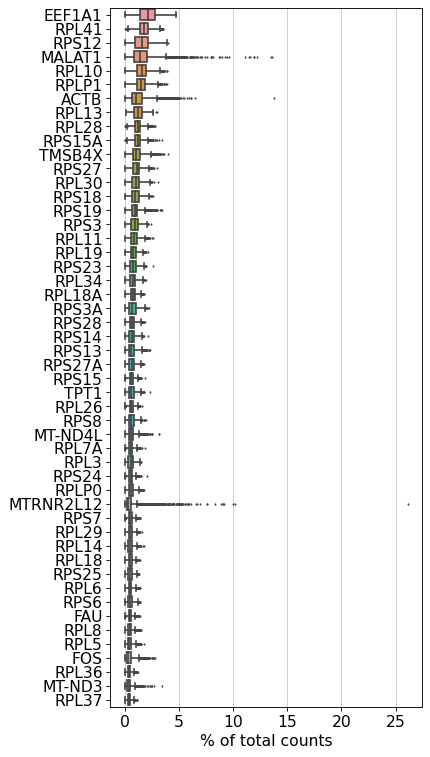

In [243]:
# highest expressed isoforms
sc.pl.highest_expr_genes(adata_short, n_top=50)

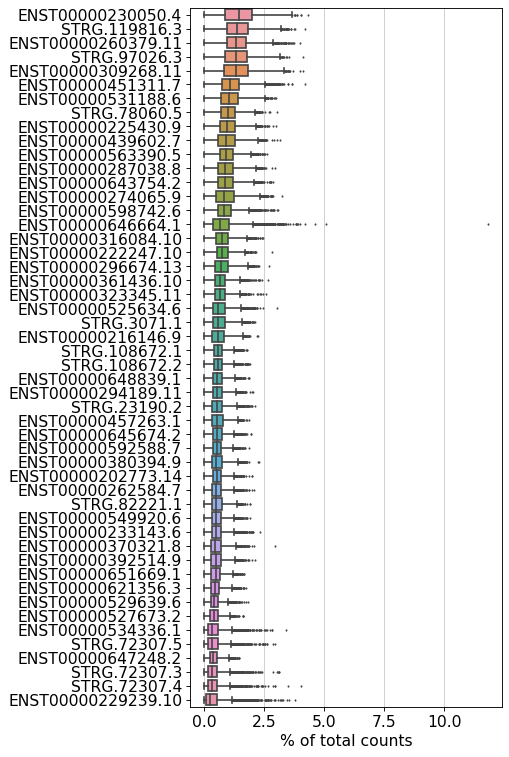

In [244]:
# highest expressed isoforms
sc.pl.highest_expr_genes(adata_long, n_top=50)

In [245]:
total_tx_expr_long = np.asarray(adata_long.X.sum(0)).flatten()
total_gene_expr_short = np.asarray(adata_short.X.sum(0)).flatten()

In [246]:
short_gene_ids = list(map(drop_version, adata_short.var[ADATA_SHORT_GENE_IDS_COL].values))
long_gene_ids = list(map(drop_version, adata_long.var[ADATA_LONG_GENE_IDS_COL].values))

In [247]:
from itertools import groupby
from operator import itemgetter

gene_id_to_tx_indices_map = dict()
for g in groupby(enumerate(long_gene_ids), key=itemgetter(1)):
    gene_id = g[0]
    tx_indices = list(map(itemgetter(0), g[1]))
    gene_id_to_tx_indices_map[gene_id] = tx_indices
    
total_gene_expr_long = []
for gene_id in short_gene_ids:
    total_gene_expr_long.append(np.sum(total_tx_expr_long[gene_id_to_tx_indices_map[gene_id]]))
total_gene_expr_long = np.asarray(total_gene_expr_long)

In [248]:
total_gene_expr_short_tpm = 1_000_000 * total_gene_expr_short / np.sum(total_gene_expr_short)
total_gene_expr_long_tpm = 1_000_000 * total_gene_expr_long / np.sum(total_gene_expr_long)

In [249]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

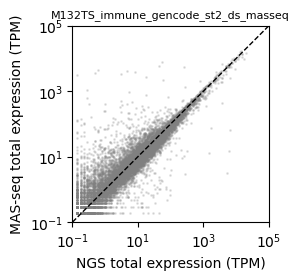

In [250]:
import matplotlib.ticker as tck

fig, ax = plt.subplots(figsize=(3, 3))

ax.plot([1e-1, 1e5], [1e-1, 1e5], '--', lw=1, color='black')
ax.scatter(total_gene_expr_short_tpm, total_gene_expr_long_tpm, s=1, alpha=0.2, color='gray')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1e-1, 1e1, 1e3, 1e5])
ax.set_yticks([1e-1, 1e1, 1e3, 1e5])
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.set_xlim((1e-1, 1e5))
ax.set_ylim((1e-1, 1e5))
ax.set_aspect('equal')
ax.set_title(output_prefix_full, fontsize=8)
ax.set_xlabel('NGS total expression (TPM)')
ax.set_ylabel('MAS-seq total expression (TPM)')
fig.tight_layout()

plt.savefig(
    os.path.join(
        repo_root, fig_output_root, output_prefix_full + "_gex_concordance.pdf"))

## Cell-level and gene-level summary statistics

In [251]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [252]:
adata_short = sc.read(harmonized_short_adata_h5_path)
adata_long = sc.read(harmonized_long_adata_h5_path)

In [253]:
adata_short_umi_counts_n = np.asarray(adata_short.X.sum(-1)).flatten()
adata_short_unique_gene_counts_n = np.asarray((adata_short.X > 0).sum(-1)).flatten()

In [254]:
adata_long_umi_counts_n = np.asarray(adata_long.X.sum(-1)).flatten()
adata_long_unique_transcript_counts_n = np.asarray((adata_long.X > 0).sum(-1)).flatten()

In [255]:
import scipy

gid_set = set(adata_long.var[ADATA_LONG_GENE_IDS_COL].values)
gid_to_g_idx = {gid: g_idx for g_idx, gid in enumerate(gid_set)}

t_idx_list = []
g_idx_list = []
values = []
for t_idx, gid in enumerate(adata_long.var[ADATA_LONG_GENE_IDS_COL].values):
    t_idx_list.append(t_idx)
    g_idx_list.append(gid_to_g_idx[gid])
    values.append(1)
    
t_idx_to_g_idx_map = scipy.sparse.coo_matrix(
    (values, (t_idx_list, g_idx_list)),
    shape=[len(adata_long.var[ADATA_SHORT_GENE_IDS_COL].values), len(gid_set)])

adata_long_X_cg = adata_long.X @ t_idx_to_g_idx_map
adata_long_unique_gene_counts_n = np.asarray((adata_long_X_cg > 0).sum(-1)).flatten()

In [256]:
from scipy.optimize import curve_fit

def exp_saturation_curve(x, a1, a2, b1, b2):
    y = x / 10_000
    return 10_000 * (a1 * y + a2 * y**2) / (1 + b1 * y + b2 * y**2)

In [257]:
x_fit = np.linspace(0, 20_000, num=100)

min_umi = 100

popt, pcov = curve_fit(
    exp_saturation_curve,
    adata_short_umi_counts_n[adata_short_umi_counts_n > min_umi],
    adata_short_unique_gene_counts_n[adata_short_umi_counts_n > min_umi], bounds=(0, 100.))

adata_short_unique_gene_counts_n_fit = exp_saturation_curve(x_fit, *tuple(popt))

popt, pcov = curve_fit(
    exp_saturation_curve,
    adata_long_umi_counts_n[adata_long_umi_counts_n > min_umi],
    adata_long_unique_transcript_counts_n[adata_long_umi_counts_n > min_umi], bounds=(0, 100.))

adata_long_unique_transcript_counts_n_fit = exp_saturation_curve(x_fit, *tuple(popt))

popt, pcov = curve_fit(
    exp_saturation_curve,
    adata_long_umi_counts_n[adata_long_umi_counts_n > min_umi],
    adata_long_unique_gene_counts_n[adata_long_umi_counts_n > min_umi], bounds=(0, 100.))

adata_long_unique_gene_counts_n_fit = exp_saturation_curve(x_fit, *tuple(popt))

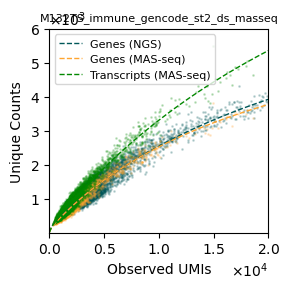

In [258]:
import colorcet as cc

fig, ax = plt.subplots(figsize=(3, 3))

alpha = 0.2
s = 1
lw = 1
adata_short_unique_gene_counts_color = list(cc.cm.glasbey(9)[:3])
adata_long_unique_gene_counts_color = list(cc.cm.glasbey(7)[:3])
adata_long_unique_transcript_counts_color = list(cc.cm.glasbey(2)[:3])

ax.scatter(adata_short_umi_counts_n, adata_short_unique_gene_counts_n, s=s, color=adata_short_unique_gene_counts_color + [alpha])
ax.scatter(adata_long_umi_counts_n, adata_long_unique_gene_counts_n, s=s, color=adata_long_unique_gene_counts_color + [alpha])
ax.scatter(adata_long_umi_counts_n, adata_long_unique_transcript_counts_n, s=s, color=adata_long_unique_transcript_counts_color + [alpha])

ax.plot(x_fit, adata_short_unique_gene_counts_n_fit, color=adata_short_unique_gene_counts_color, lw=lw, linestyle='--', label='Genes (NGS)')
ax.plot(x_fit, adata_long_unique_gene_counts_n_fit, color=adata_long_unique_gene_counts_color, lw=lw, linestyle='--', label='Genes (MAS-seq)')
ax.plot(x_fit, adata_long_unique_transcript_counts_n_fit, color=adata_long_unique_transcript_counts_color, lw=lw, linestyle='--', label='Transcripts (MAS-seq)')

ax.set_xlim((0, 2e4))
ax.set_ylim((1, 6e3))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,1), useMathText=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1), useMathText=True)

ax.legend(fontsize=8)
ax.set_xlabel('Observed UMIs')
ax.set_ylabel('Unique Counts')
ax.set_title(output_prefix_full, fontsize=8)
fig.tight_layout()

plt.savefig(
    os.path.join(
        repo_root, fig_output_root, output_prefix_full + "_saturation.pdf"))